In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns
import pickle
import copy
import jaxopt

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot
import src.exp_utils as exp_utils
import experiments.mixture as exp_mix

# Explore

In [273]:
np.random.seed(2024)

nmix = 2
dim = 2
std = 1.
n = 500

scale = 5.
params_setup = pickle.load(open(f"../data/mixture/setup_d{d}.pkl", "rb"))

# mixture means and ratios
# mean_ls = np.random.uniform(low=-10., high=10., size=(nmix, dim))
# params_setup = pickle.load(open(f"../data/mixture/setup_d{d}.pkl", "rb"))
mean_ls = params_setup["means"][scale]
# mean_ls = np.array([[5], [-5.]])

# model_ratio_ls = np.random.uniform(size=(nmix))
# model_ratio_ls = model_ratio_ls / np.sum(model_ratio_ls)
model_ratio_ls = params_setup["model_ratios"]
# model_ratio_ls = np.array([0.5, 0.5])

# data_ratio_ls = np.random.uniform(size=(nmix))
# data_ratio_ls = data_ratio_ls / np.sum(data_ratio_ls)
data_ratio_ls = params_setup["data_ratios"]
# data_ratio_ls = np.array([0.3, 0.7])

In [274]:
print(model_ratio_ls)
print(data_ratio_ls)

[0.00636835 0.25084102 0.2007961  0.32056046 0.22143407]
[0.22575827 0.16715244 0.08386594 0.24940653 0.27381682]


In [275]:
np.random.seed(10)
X = exp_mix.sample_mixture(n, mean_ls, data_ratio_ls, std)

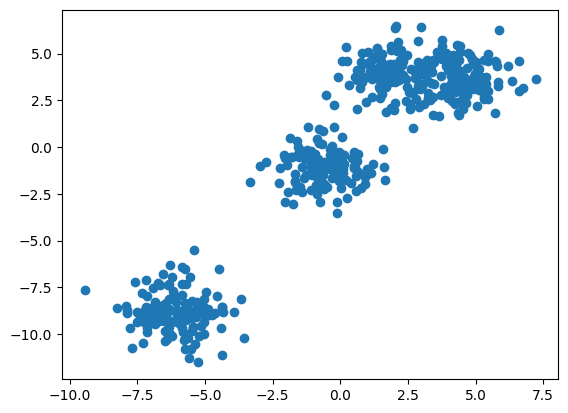

In [276]:
# _ = plt.hist(X[:, 0].reshape(-1), bins=20, density=True)
plt.scatter(X[:, 0], X[:, 1])

In [245]:
log_prob_fn = exp_mix.make_log_prob(mean_ls, model_ratio_ls, std)
score_fn = exp_mix.make_score(mean_ls, model_ratio_ls, std)

xx = X[:10]
xx = np.eye(dim)[:1] * 100.
print(log_prob_fn(xx))
print(score_fn(xx))

[-4159.235]
[[-90.91039    7.176021]]


In [204]:
np.random.seed(10)
nrep = 20
n = 500

Xs = jnp.empty((nrep, n, dim), dtype=jnp.float32)
scores = jnp.empty((nrep, n, dim), dtype=jnp.float32)

score_fn = exp_mix.make_score(mean_ls, model_ratio_ls, std)

for i in range(nrep):
    X = exp_mix.sample_mixture(n, mean_ls, data_ratio_ls, std)
    Xs = Xs.at[i].set(X)

    score = score_fn(X)
    scores = scores.at[i].set(score)

res = exp_utils.run_tests(
    samples=Xs, scores=scores, hvps=None, hvp_denom_sup=None,
    theta=0.1, bw="med", alpha=0.05, verbose=True,
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.00s/it]


In [205]:
res["standard"]["stat"]

[Array(0.00207557, dtype=float32),
 Array(0.00646279, dtype=float32),
 Array(0.00125337, dtype=float32),
 Array(0.00236788, dtype=float32),
 Array(0.00138749, dtype=float32),
 Array(0.00236041, dtype=float32),
 Array(0.00262997, dtype=float32),
 Array(0.00522922, dtype=float32),
 Array(0.00175518, dtype=float32),
 Array(0.00110197, dtype=float32),
 Array(0.00076564, dtype=float32),
 Array(0.00156009, dtype=float32),
 Array(0.0031527, dtype=float32),
 Array(0.00348922, dtype=float32),
 Array(0.00110729, dtype=float32),
 Array(0.00501264, dtype=float32),
 Array(0.00411134, dtype=float32),
 Array(0.00943106, dtype=float32),
 Array(0.00253333, dtype=float32),
 Array(0.00186612, dtype=float32)]

In [206]:
res["standard"]["rej"]

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]

# Load

In [110]:
n = 1000
d = 2
res_stats = pickle.load(open(f"../data/mixture/stats_n{n}_d{d}.pkl", "rb"))

scale_ls = list(res_stats.keys())
scale_ls

[1.0, 2.0, 3.0, 5.0, 10.0, 20.0]

In [111]:
tau = pickle.load(open(f"../data/mixture/tau_d{d}.pkl", "rb"))
tau

{1.0: Array(4.348198, dtype=float32),
 2.0: Array(16.591635, dtype=float32),
 3.0: Array(35.419308, dtype=float32),
 5.0: Array(104.272896, dtype=float32),
 10.0: Array(418.5178, dtype=float32),
 20.0: Array(1780.0149, dtype=float32)}

In [112]:
# change theta
eps0_ls = [0.005, 0.01, 0.05]
plot_df_ls = {}

for i, eps0 in enumerate(eps0_ls):
    # change theta
    res_stats_new = copy.deepcopy(res_stats)
    for scale in scale_ls:
        theta_new = eps0 * tau[scale]**0.5
        
        res_stats_new[scale] = exp_utils.change_theta(res_stats_new[scale], ["tilted_r_bootmax", "tilted_r_boot"], theta_new)
    
    methods = {"standard": "IMQ", "tilted": "Tilted", "tilted_r_boot": "R-KSD-Boot", "tilted_r_bootmax": "R-KSD-BootMax"}
    
    plot_df = {"scale": [], "nonsq_stat": [], "method": [], "rej": []}
    for scale in scale_ls:
        for m, m_label in methods.items():
            rr = res_stats_new[scale][m]
            plot_df["nonsq_stat"].extend(np.array(rr["nonsq_stat"]).tolist())
            plot_df["scale"].extend([scale] * len(rr["nonsq_stat"]))
            
            plot_df["rej"].extend(rr["rej"])
            plot_df["method"].extend([m_label] * len(rr["nonsq_stat"]))
    
    plot_df = pd.DataFrame(plot_df)
    plot_df_ls[eps0] = plot_df

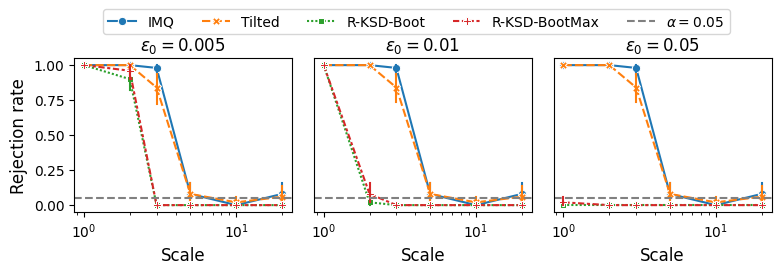

In [117]:
_, axes = plt.subplots(ncols=len(eps0_ls), figsize=(3*len(eps0_ls), 2))

for i, eps0 in enumerate(eps0_ls):
    plot_df = plot_df_ls[eps0]

    ax = axes[i]
    _ = sns.lineplot(ax=ax, data=plot_df, x="scale", y="rej", hue="method", style="method", markers=True, err_style="bars")
    ax.axhline(0.05, color="grey", linestyle="--", label=r"$\alpha=0.05$")
    ax.set_xlabel("Scale", fontsize=12)
    ax.set_ylabel("Rejection rate", fontsize=12)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xscale("log")
    ax.set_title(rf"$\epsilon_0 = ${eps0}")
    if i > 0:
        ax.legend([],[], frameon=False)
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel("")

lgd = axes[0].legend(bbox_to_anchor=(0.1, 1.11, 1, 0.2), loc="lower left", ncol=6)

plt.subplots_adjust(wspace=0.1)
# plt.savefig("../figs/robust/mixture.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")

In [95]:
params_setup = pickle.load(open(f"../data/mixture/setup_d{d}.pkl", "rb"))
X_res = pickle.load(open(f"../data/mixture/X_res_n{n}_d{d}.pkl", "rb"))

In [106]:
scale_plot = [2., 10.]
plot_lims = [[-6, 6], [-25, 25]]
x_plot_ls = []

lp_ls = []
for i, scale in enumerate(scale_plot):
    x = np.linspace(plot_lims[i][0], plot_lims[i][1], 1001)
    
    log_prob_fn = exp_mix.make_log_prob(params_setup["means"][scale], params_setup["model_ratios"], std=1)
    
    lp = np.empty((x.shape[0], x.shape[0]))
    for j, x1 in tqdm(enumerate(x), total=x.shape[0]):
        X = np.empty((x.shape[0], 2))
        X[:, 0] = x1
        X[:, 1] = x
        
        lp_X = log_prob_fn(X)
        lp[j] = lp_X

    x_plot_ls.append(x)
    lp_ls.append(lp)

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

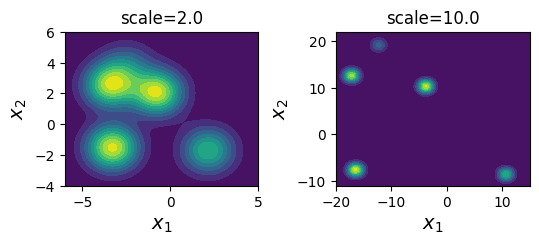

In [109]:
_, axes = plt.subplots(ncols=2, figsize=(3*2, 2))

xlims = [[-6, 5], [-20, 15]]
ylims = [[-4, 6], [-11, 22]]

for i, ax in enumerate(axes):
    x = x_plot_ls[i]
    y_plot, x_plot = np.meshgrid(x, x)
    ax.contourf(x_plot, y_plot, np.exp(lp_ls[i]), levels=10)
    ax.set_xlim(xlims[i])
    ax.set_ylim(ylims[i])
    ax.set_xlabel(r"$x_1$", fontsize=14)
    ax.set_ylabel(r"$x_2$", fontsize=14)
    ax.set_title(f"scale={scale_plot[i]}")

plt.subplots_adjust(wspace=0.4)
# plt.savefig("../figs/robust/mixture_den.pdf", bbox_inches="tight")